In [8]:
%load_ext autoreload
%autoreload 2
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
import numpy as np
import matplotlib.pyplot as plt
config = {
    "version": 1,
    "controllers": {
        "con1": {
            "type": "opx1",
            "analog_outputs": {
                1: {"offset": +0.0},
                2: {"offset": +0.0},
            },
        }
    },
    "elements": {
        "qe1": {
            "singleInput": {"port": ("con1", 1)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
        "qe2": {
            "singleInput": {"port": ("con1", 2)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
    },
    "pulses": {
        "constPulse": {
            "operation": "control",
            "length": 1000,  # in ns
            "waveforms": {"single": "const_wf"},
        },
    },
    "waveforms": {
        "const_wf": {"type": "constant", "sample": 0.2},
    },
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# QUA Variables and math

The QUA langaugage has variables of three data types: `int`egers, `fixed` point numbers and `booleans`. You can also have vectors of such types (but not of mixed types). These variables can be populated by mathematical operations or measurements. There are also reserved variables you can write directly from python, but this will not be covered in this demo.

The `fixed` point data type may be less familiar to some. It's a way to represent decimal numbers on hardware. Because there is a finite amount or memory allocated for each number, you need to decide on a way to represent the integer part and the decimal part of this number. On a personal computer, this is done with a floating-point representation which is able to decide how many bits are allocated for the integer part and how many are for the decimal (hence -floating point). This is computationally intensive so, for the time being, we have a fixed representation. We allocate 4 bits for the integer part and 28 for the decimal, giving a number range between -2 and 2 (in fact, slighly less so try not to get to 2 exactly).

QUA's real time mathematics capabilities are extensive. We include arithmatic operations, trigonometry, vector operations, random number generation and more. 

The following example show the simplest possible example: storing a number to a variable and then saving it to be read outside the program.

In [2]:
with program() as prog:
    a = declare(int,value=10)
    save(a,"a")

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")

    

2021-04-01 08:54:02,908 - qm - INFO - Performing health check
2021-04-01 08:54:03,146 - qm - INFO - Health check passed
2021-04-01 08:54:03,326 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 08:54:03,363 - qm - INFO - Flags: 
2021-04-01 08:54:03,364 - qm - INFO - Simulating Qua program

The program returned the value: a=[10]


## Arithmatic

A program can also perform basic mathematical operations on variables, as is shown below:

In [3]:
with program() as prog:
    a = declare(int,value=10)
    assign(a,2*(a+1))
    save(a,"a")

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")

    

2021-04-01 08:54:05,109 - qm - INFO - Performing health check
2021-04-01 08:54:05,116 - qm - INFO - Health check passed
2021-04-01 08:54:05,148 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 08:54:05,161 - qm - INFO - Flags: 
2021-04-01 08:54:05,162 - qm - INFO - Simulating Qua program

The program returned the value: a=[22]


## Trigonometry

Trigonometric operations return fixed point numbers. We have `cos`, `sin` implemented, as well as `cos2pi` and `sin2pi` for which `cos2pi(arg)=cos(2pi * arg)`. This solves you the head scratching moment you may encounter when trying to represent $\pi$ using a fixed point number. 

In [11]:
with program() as prog:
    a = declare(fixed)
    assign(a,Math.cos2pi(0.5))
    save(a,"a")

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")


2021-04-01 14:15:10,964 - qm - INFO - Performing health check
2021-04-01 14:15:10,981 - qm - INFO - Health check passed
2021-04-01 14:15:10,997 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 14:15:11,004 - qm - INFO - Flags: 
2021-04-01 14:15:11,005 - qm - INFO - Simulating Qua program

The program returned the value: a=[-1.]


## Using variables when playing pulses

The example below shows how random numbers can be generated in QUA. The randomly generated integer is then used to play a pulse with a random duration. 

Run it a few times and see. 

2021-04-01 08:54:09,492 - qm - INFO - Performing health check
2021-04-01 08:54:09,496 - qm - INFO - Health check passed
2021-04-01 08:54:09,518 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 08:54:09,531 - qm - INFO - Flags: 
2021-04-01 08:54:09,534 - qm - INFO - Simulating Qua program

The program returned the value: a=[2]

The program returned the value: b=[0.00320124]


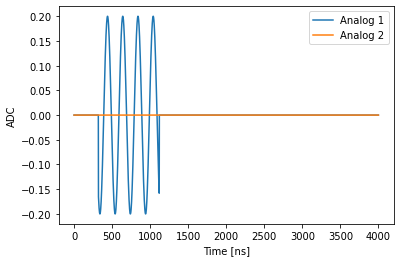

In [5]:
with program() as prog:
    r = Random()
    a = declare(int)
    b = declare(fixed)
    assign(a, r.rand_int(10)) # a will be a number between 0 and 9
    assign(b, r.rand_fixed()) # b will be a number between 0.0 and 1.0
    play("playOp","qe1",duration=100*a)

    save(a,"a")
    save(b,"b")

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

a = res.a.fetch_all()['value']
b = res.b.fetch_all()['value']

print(f"\nThe program returned the value: a={a}")
print(f"\nThe program returned the value: b={b}")


samples = job.get_simulated_samples()
samples.con1.plot()


## Vectors and vector operations

2021-04-01 14:16:12,280 - qm - INFO - Performing health check
2021-04-01 14:16:12,285 - qm - INFO - Health check passed
2021-04-01 14:16:12,309 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 14:16:12,322 - qm - INFO - Flags: 
2021-04-01 14:16:12,324 - qm - INFO - Simulating Qua program


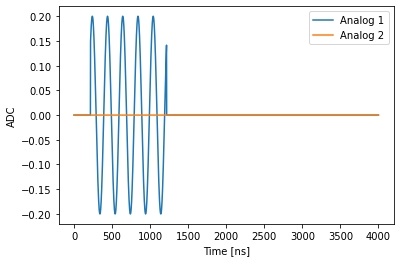

In [13]:
with program() as prog:
        play('playOp','qe1')
QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns
res=job.result_handles

# a = res.a.fetch_all()['value']
# b = res.b.fetch_all()['value']



samples = job.get_simulated_samples()
samples.con1.plot()

## More math

There are more mathematical operations defined in QUA (and the list is rapidly growing). Here's a current list:

In [22]:
method_list = [method for method in dir(Math) if method.startswith('__') is False]

print(method_list)

['abs', 'argmax', 'argmin', 'cos', 'cos2pi', 'div', 'dot', 'exp', 'inv', 'inv_sqrt', 'ln', 'log', 'log10', 'log2', 'max', 'min', 'pow', 'pow2', 'sin', 'sin2pi', 'sqrt', 'sum']


## Excercises

1. Use a few of the methods above in a QUA program